In [60]:
import logging
import math
import os

logging.basicConfig(level=logging.INFO)

import torch
import librosa

torch.set_grad_enabled(False)

import cached_conv as cc
import gin
import nn_tilde
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from absl import flags, app

import sys, os
import rave
import rave.model
import rave.blocks
import rave.core
import rave.resampler
from rave.pitch_utils import get_f0_norm, extract_f0_median_std, get_pitch, one_hot, quantize_f0_norm
import IPython.display as ipd

from transform import ConstantQTransform

In [72]:
hop_length = 1024
fmin = 32.7
bins = 190
bins_per_octave = 24
sr = 44100

cqt = ConstantQTransform(hop_length=hop_length, fmin=fmin, bins=bins, bins_per_octave=bins_per_octave, sample_rate=sr)
x, _ = librosa.load("libri.wav", sr=sr, mono=True)
x = torch.tensor(x[:131072]).unsqueeze(0)
print(x.shape)
num_frames = x.shape[-1] // hop_length
x_cqt = cqt(x)[:, :, :num_frames]
print(x_cqt.shape)

cqt_center = x_cqt.shape[1] // 2

torch.Size([1, 131072])
torch.Size([1, 190, 128])


In [62]:
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

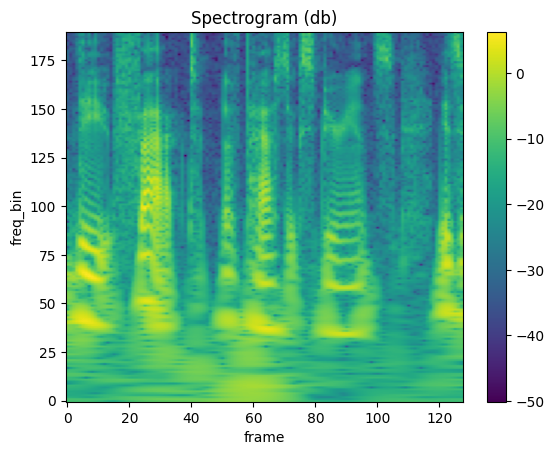

In [63]:
plot_spectrogram(x_cqt[0])

In [68]:
class RelativePitchDifferenceLoss(nn.Module):
    """Relative pitch difference loss.

    Introduced in Gfeller et al., 2020, _Spice: Self-supervised pitch estimation_
    """

    def __init__(
        self,
        cqt_center: int,
        cqt_shift_min: int,
        cqt_shift_max: int,
        pitch_freq: int,
        delta: float,
        sigma: float,
    ) -> None:
        super().__init__()
        self.cqt_center = cqt_center
        self.cqt_shift_min = cqt_shift_min
        self.cqt_shift_max = cqt_shift_max
        self.pitch_freq = pitch_freq
        self.delta = delta
        self.sigma = sigma

    def forward(
        self,
        cqt: torch.Tensor,
        #pitch: torch.Tensor,
        bsize: int,
    ) -> torch.Tensor:
        random_transposition = torch.randint(
            self.cqt_shift_min,
            self.cqt_shift_max + 1,  # for inclusive range
            (bsize,),
            device=cqt.device,
        )
        # real start index
        start = random_transposition + self.cqt_center
        # sampled
        transposed_cqt = torch.stack(
            [cqt_[i : i + self.pitch_freq] for cqt_, i in zip(cqt, start)]
        )

        print(transposed_cqt.shape)

        """
        # [B, N]
        predicted_transposed_pitch, _, _, _ = pitch_encoder(transposed_cqt)

        # pitch consistency
        return F.huber_loss(
            predicted_transposed_pitch.log2()
            + self.sigma * random_transposition[:, None],
            pitch.log2(),
            delta=self.delta,
        )
        """
        return transposed_cqt

pitch_freq = 160
cqt_center = (bins - pitch_freq) // 2
cqt_shift_min = -12
cqt_shift_max = 12
delta = 0.125
sigma = 0.5

print(cqt_center)

p_loss = RelativePitchDifferenceLoss(cqt_center, cqt_shift_min, cqt_shift_max, pitch_freq, delta, sigma)
t_cqt = p_loss(x_cqt, 1)


15
torch.Size([1, 153, 128])


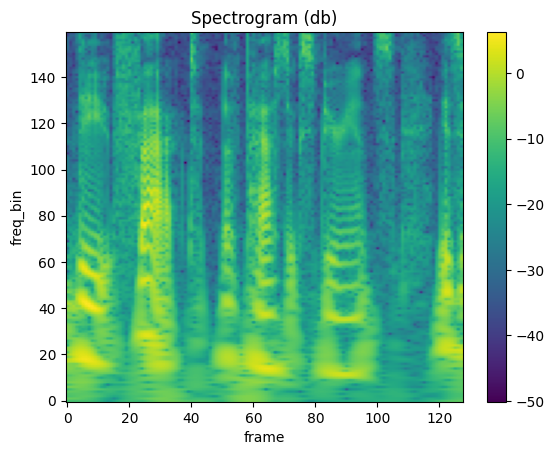

In [65]:
plot_spectrogram(t_cqt[0])

In [73]:
from rave.blocks import GeneratorV2Pitch

ImportError: cannot import name 'GeneratorV2Pitch' from 'rave.blocks' (/home/jupyter-arbu/RAVE/rave/blocks.py)